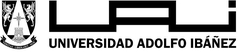

#**Laboratorio 01:** Clasificación lineal multiclase y redes neuronales convolucionales

**Fecha de Entrega:** 23 de abril de 2021

# Integrante(s): 
(*3 alumnos como máximo*)


1.   Alumno 01
2.   Alumno 02 (Opcional)
3.   Alumno 03 (Opcional)


# 1. Introducción

##1.1 Descripción del problema

Dada la base de datos vista en clases de imágenes de perros y gatos, se desea comparar el rendimiento de un clasificador lineal multiclase con respecto a un clasificador basado en redes neuronales profunda del tipo convolucional multiclase. 

Para realizar este trabajo, debe implementar ambos clasificadores utilizando el código visto en clases.

El documento de laboratorio debe contener las siguientes secciones para explicar cada uno de los experimentos:

*  **Librerías**: Debe indicar todas las librerías que serán utilizadas en el laboratorio. Prestando atención en **no colocar librerías** que no serán utilizadas en los experimentos.
*  **Carga de la base de datos**: Incluye el código necesario para poder cargar los datos y la construcción de los _dataloader_.
*  **Diseño del modelo**: Describir brevemente (en formato texto) la arquitectura de la red neuronal a implementar. Indicar la cantidad de datos de entrada, capas ocultas, salidas, número de neuronas, etc.
* **Parámetros y configuración del modelo**: Esta sección debe contener una breve explicación de los parámetros utilizados para la construcción del modelo y una implementación en pytorch.
* **Entrenamiento y validación**: Se deben describir metodológicamente como se realizará el entrenamiento. Definir hiperparámetros, función de coste, etc. Además, debe implementar el código adecuado para la optimización de parámetros utilizando descenso de gradiente (estocástico u otro). 
* **Pruebas**: Implementar el código que permita probar los parámetros, hiperparámetros y modelo, obtenido en la etapa de aprendizaje (entrenamiento). 
* **Resultados**: Calcular las métricas de rendimiento del clasificador para la etapa de entrenamiento y para pruebas. Explique los resultados obtenidos. Utilice la matriz de confusión, presición, recall y tasa de acierto para explicar el comportamiento del modelo.
* **Conclusiones**: La conclusión consiste en sintetizar brevemente los puntos más relevantes, aportando nuevos **conocimientos** explorados en el laboratorio. Las conclusiones no son un resumen de lo realizado sino a lo que ha llevado el desarrollo del proyecto, no perdiendo de vista los objetivos planteados desde el principio y los resultados obtenidos. Es usual concluir con lo que queda por hacer, o sugerencias para mejorar.


##1.2   Objetivos

### Objetivo general
Comparar el rendimiento de dos clasificadores que sean capaces de predecir la existencia de un perro o un gato en una imagen.

### Objetivos específicos
1. Cargar las imágenes e etiquetas de una base de datos basada en directorios y subdirectorios.
2. Entrenar un modelo lineal multiclase para detectar imágenes de perros y gatos.
3. Entrenar un modelo basado en redes neuronales convolucionales para detectar imágenes de perros y gatos.
4. Probar ambos modelos y obtener las métricas de rendimiento: Tasa de acierto (accuracy), precisión (), (recall). 
5. Comparar ambos modelos e indicar cual de los dos tiene el mejor comportamiento y porqué.

##1.3 Librerías 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import numpy as np
import PIL

## 1.4 Carga de base de datos desde google drive

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Como se van a comparar dos modelos de clasificción, no se harán transformaciones en las imágenes. Tampoco se mezclará el conjunto de entrenamiento. Esto tienee como objetivo comparar ambos entrenamientos y modelos en las mismas condiciones. La idea detrás del laboratorio es encontrar los mejores parámetros e hiperparámtros para ambos modelos con los mismos datos para luego poder compararlos.


In [3]:

batch_size  = 32

data_transform = transforms.Compose([
       transforms.Resize((28,28)),
       transforms.Grayscale(num_output_channels=1),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.5], std=[0.5])])

# Carga de las imágenes
gatos_perros_train = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/training_set',
                                           transform=data_transform)
gatos_perros_valid = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/valid_set',
                                           transform=data_transform)
gatos_perros_test = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/test_set',
                                           transform=data_transform)

# Conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(gatos_perros_train,
                                             batch_size=32, shuffle=True,
                                             num_workers=2)

# Conjunto de validación
valid_loader = torch.utils.data.DataLoader(gatos_perros_valid,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

# Conjunto de pruebas
test_loader = torch.utils.data.DataLoader(gatos_perros_test,
                                             batch_size=32, shuffle=False,
                                             num_workers=2)

print('Ver la dimension de la imagen:')
print(gatos_perros_train[0][0].shape)
print('Etiqueta:')
print(gatos_perros_train[0][1])
#

Ver la dimension de la imagen:
torch.Size([1, 28, 28])
Etiqueta:
0


## 1.5 Visualizar las imágenes de la base de datos

En ciencia de datos siempre es bueno revisar como se está cargando la base de datos con el fin de comprobar la consistencia de estos.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


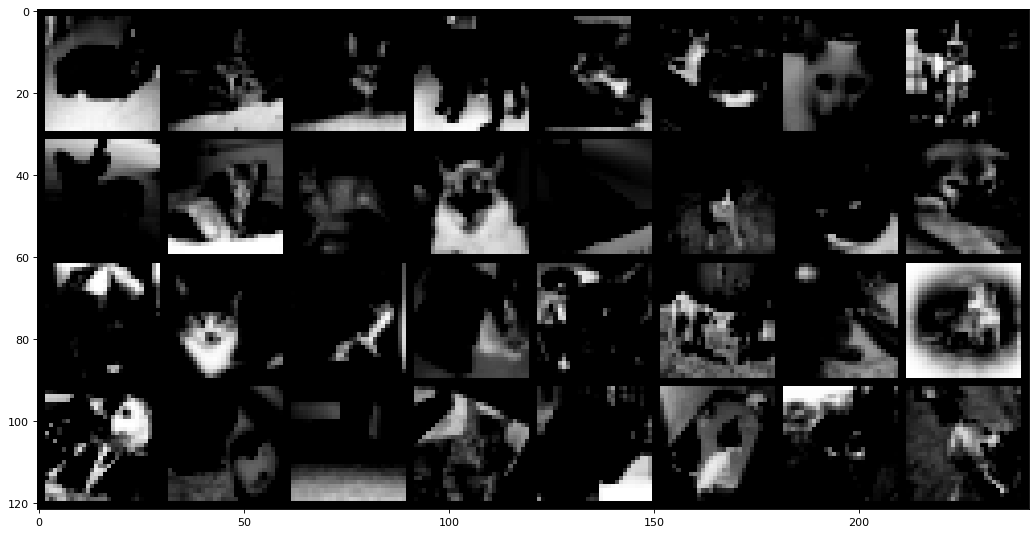

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(num=None, figsize=(16, 14), dpi=80, facecolor='w', edgecolor='k')

def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))

# Obtener imagenes
data_iter = iter(train_loader)
images, labels = data_iter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

In [49]:
labels

tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1])

#2. Clasificador lineal multiclase

Desarrollo de los experimentos para un clasificador lineal multiclase utilizando la base de datos de imágenes de perros y gatos vista en clases.


## 2.1 Diseño del modelo propuesto

Explicar arquitectura clasificador multiclase:
* Entrada de datos
* Modelo lineal propuesto
* Salida esperada de datos

## 2.2 Parámetros y configuración del modelo

Explicar los parámetros e hiperparámetros seleccionados para la implementación del modelo, función de pérdida y modelo de optimización.

In [23]:
import torch 
import torch.nn as nn
import torch.optim as optim

# Implementamos el modelo de imagenes 28 X 28 y con una clasificacion de dos clases
linear_model = nn.Linear(784,2)

# Configurar hiperparametros
learning_rate = 1e-4 # 
weight_decay = 0.001 # 
num_epochs = 50

# Configuramos la función de pérdida
criterion = nn.CrossEntropyLoss()

# Configuramos modelo de optimización
optimizer = optim.SGD(linear_model.parameters(), lr=learning_rate, weight_decay=weight_decay)



## 3.3 Entrenamiento

Implementar entrenamiento.

In [24]:
def get_accuracy(model, data):
  loader = torch.utils.data.DataLoader(data, batch_size=50)
  correct, total = 0,0
  for xs, ts in loader:
    xs = xs.view(-1,784) # Convertir la imagen en un vector
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1]  # Obtener el indice de la clasificacion 
    correct += pred.eq(ts.view_as(pred)).sum().item()
    total += int(ts.shape[0])
  return correct / total

In [25]:
losses = []
iters_sub, train_acc, val_acc = [], [] ,[]

for epoch in range(num_epochs):
  losses_it = []
  for xs, ts in iter(train_loader):
    if len(ts) != batch_size:
      continue
    xs = xs.view(-1, 784) # Convertir la imagen en un vector
    zs = linear_model(xs) # Calcular la prediccion
    loss = criterion(zs, ts) # Calcular el loss total
    loss.backward() # Calcular gradientes
    optimizer.step() # Actualizar parámetros
    optimizer.zero_grad() # Borrar todos los cálculos anteriores en Pytorch
    losses_it.append(float(loss)/batch_size)

  # Guardar la información de entrenamiento de cada ciclo
  print(f'Epoch: {epoch}... \n', end='')
  losses.append(sum(losses_it)/len(losses_it)) # Calcular el loss promedio
  iters_sub.append(epoch + 1)
  train_acc.append(get_accuracy(linear_model, gatos_perros_train))
  val_acc.append(get_accuracy(linear_model, gatos_perros_valid))

  


Epoch: 0... 
Epoch: 1... 
Epoch: 2... 
Epoch: 3... 
Epoch: 4... 
Epoch: 5... 
Epoch: 6... 
Epoch: 7... 
Epoch: 8... 
Epoch: 9... 
Epoch: 10... 
Epoch: 11... 
Epoch: 12... 
Epoch: 13... 
Epoch: 14... 
Epoch: 15... 
Epoch: 16... 
Epoch: 17... 
Epoch: 18... 
Epoch: 19... 
Epoch: 20... 
Epoch: 21... 
Epoch: 22... 
Epoch: 23... 
Epoch: 24... 
Epoch: 25... 
Epoch: 26... 
Epoch: 27... 
Epoch: 28... 
Epoch: 29... 
Epoch: 30... 
Epoch: 31... 
Epoch: 32... 
Epoch: 33... 
Epoch: 34... 
Epoch: 35... 
Epoch: 36... 
Epoch: 37... 
Epoch: 38... 
Epoch: 39... 
Epoch: 40... 
Epoch: 41... 
Epoch: 42... 
Epoch: 43... 
Epoch: 44... 
Epoch: 45... 
Epoch: 46... 
Epoch: 47... 
Epoch: 48... 
Epoch: 49... 


### Gráfico de función de pérdida del conjunto de entrenamiento y validación

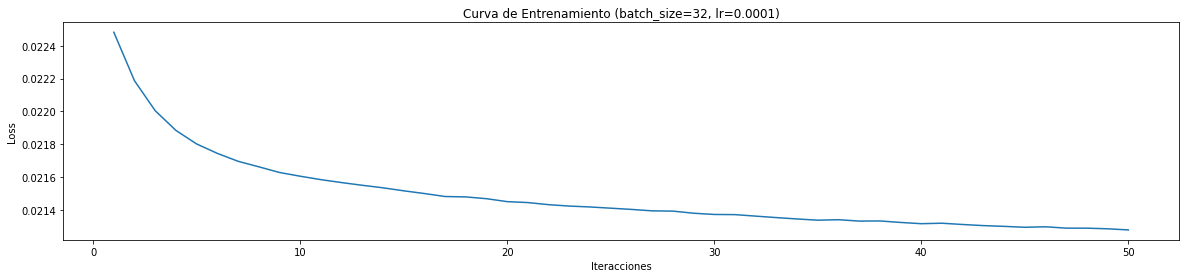

In [26]:
plt.figure(figsize=(20,4))
plt.title("Curva de Entrenamiento (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iters_sub, losses, label="Entrenamiento")
plt.xlabel("Iteracciones")
plt.ylabel("Loss")
plt.show()

### Gráfico de tasa de acierto del conjunto de entrenamiento y validación

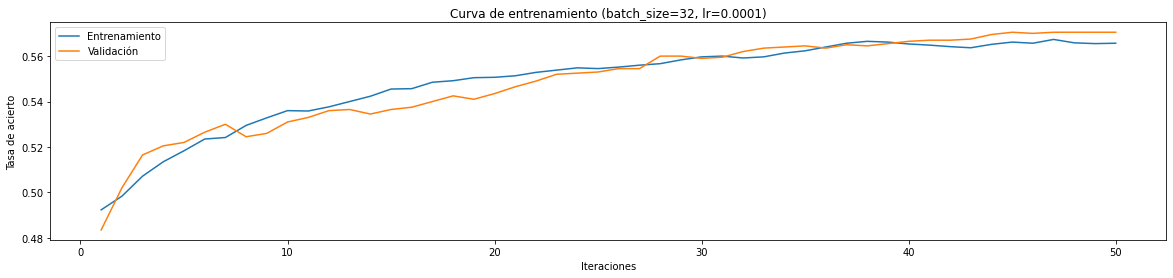

In [27]:
plt.figure(figsize=(20, 4))
plt.title("Curva de entrenamiento (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iters_sub, train_acc, label="Entrenamiento")
plt.plot(iters_sub, val_acc, label="Validación")
plt.xlabel("Iteraciones")
plt.ylabel("Tasa de acierto")
plt.legend(loc='best')
plt.show()


### Visualizar la matriz de pesos resultante
Mostrar una imagen con las matrices resultantes para el problema multiclase.

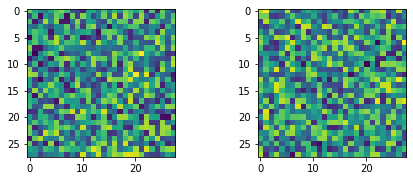

In [29]:
# Obtengo los parámetros en formato diccionario
d = dict(linear_model.named_parameters())
# Selecciono solo los parámetros que ajunta la regresión lineal
w = d['weight']

import matplotlib.pyplot as plt


f = plt.figure(figsize=(20,6))
# Por cada vector de parámetros pesos grafico (10x728)
for index, template in enumerate(w):
  template = template.detach().numpy().reshape(28,28)
  plt.subplot(2, 5, index+1)
  plt.imshow(template)

## 2.3 Pruebas

Explicar como se realizarán los experimentos y su pruebas. 

Los experimentos del conjunto de pruebas dependen de los hiperparámetros obtenidos en el entrenamiento. Explicar como son fijados esos hiperparámetros para el conjunto de prueba.

In [52]:
def get_accuracy_2(model, data):
  loader = torch.utils.data.DataLoader(data)
  correct, total = 0,0
  for xs, ts in loader:
    xs = xs.view(-1,784) # Convertir la imagen en un vector
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1]  # Obtener el indice de la clasificacion 
    correct += pred.eq(ts.view_as(pred)).sum().item()
    total += int(ts.shape[0])
  return np.ravel(pred.numpy())

In [103]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

In [106]:
linear_model(images[0])

RuntimeError: ignored

## 2.4 Resultados

Mostrar los resultados del **entrenamiento** y **pruebas**. 
Utilizar métricas para mostrar bondad del modelo.(Matríz de confusión)
Utilizar gráficos. Explicar los resultados obtenidos.

### Matriz de confusión

Debe construir una para entrenamiento y otra para pruebas

|            	| Perro Pred. 	| Gato Pred. 	 |
|------------	|:-------------:|:------------:|
| Perro Real 	|      00     	|     00     	 |
| Gato Real  	|      00     	|     00     	 |

### Métricas

Debe construir una para entrenamiento y otra para pruebas

|           	| Clase Perro 	| Clase Gato 	 |
|-----------	|:-------------:|:------------:|
| Precisión 	|    00.00%  	  |    00.00%  	 |
| Recall    	|    00.00%    	|    00.00%  	 |

| Tasa de Acierto Global 	| 00.00% 	|
|------------------------	|:------:	|


#### Matriz de confusión para el conjunto de entrenamiento




In [91]:
from sklearn.metrics import confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device=device)
lbllist=torch.zeros(0,dtype=torch.long, device=device)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(torch.utils.data.DataLoader(gatos_perros_train, batch_size=50)):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = linear_model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1)])
        lbllist=torch.cat([lbllist,classes.view(-1)])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

RuntimeError: ignored

In [148]:
import pandas as pd

etiquetas = []
predicciones = []

for i in range(len(gatos_perros_test)):
    etiqueta = gatos_perros_test[i][1]
    etiquetas.append(etiqueta)
    z = linear_model((gatos_perros_test[i][0]).view(-1,784))
    pred = z.max(1, keepdim=True)[1]
    pred = pred.numpy()
    predicciones.append(pred)

etiquetas = np.ravel(etiquetas)
predicciones = np.ravel(predicciones)

In [150]:
from sklearn.metrics import confusion_matrix

In [179]:
pd.DataFrame(confusion_matrix(1-etiquetas,1-predicciones),columns=['Perro','Gato'],index=['Perro','Gato'])

,Perro,Gato
Perro,496,504
Gato,376,624


[texto del enlace](https://)

In [199]:
etiquetas[-2]

1

In [200]:
predicciones[-2]

0

In [201]:
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(gatos_perros_test[-2][0])

In [203]:
def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))

In [178]:
gatos_perros_test[1999][1]

1

In [120]:
import pandas as pd

etiquetas = []
predicciones = []

for i in range(len(gatos_perros_train)):
    etiqueta = gatos_perros_train[i][1]
    etiquetas.append(etiqueta)
    z = linear_model((gatos_perros_train[i][0]).view(-1,784))
    pred = z.max(1, keepdim=True)[1]
    pred = pred.numpy()
    predicciones.append(pred)

etiquetas = np.ravel(etiquetas)
predicciones = np.ravel(predicciones)

tensor([[ 0.1923, -0.2952]], grad_fn=<AddmmBackward>)

tensor([[0]])

In [87]:
etiquetas = []
for i in range(3):
    etiquetas.append(i)
etiquetas

[0, 1, 2]

#3. Clasificador red neuronal profunda convolucional

Desarrollo de los experimentos para un clasificador basado en redes neuronales profundas. Se utiliza una arquitectura de redes neuronales convolucionales.


## 3.1 Diseño del modelo propuesto

Explicar arquitectura neuronal:
* Entrada de datos
* Modelo de red neural propuesto
* Salida esperada de datos

Respuesta:


## 3.2 Parámetros y configuración del modelo

Explicar los parámetros e hiperparámetros seleccionados para la implementación del modelo, función de pérdida y modelo de optimización.

In [194]:
# Configurar Hiperametros

num_epochs = 70
num_classes = 2
batch_size = 32
learning_rate = 0.0001
weight_decay = 0.01

In [195]:
# Implementar modelo

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=512, kernel_size=3)
        self.conv2 = nn.Conv2d(512, 1024, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(25*1024, 1024) # Calculo (ultimo tamaño filtrado es de 5x5 y son 20 filtros)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x): # Calcular la predicción
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [196]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [197]:
#Optimizacion del Modelo
model = CNN().to(device)
print(model)

# Inicializar los pesos de la red
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.ones_(m.bias)

model.apply(weights_init)

# Configurar función de pérdida
criterion = nn.CrossEntropyLoss()

# Configurar modelo de optimizacion

optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, weight_decay=weight_decay)
#optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate, weight_decay=weight_decay)

CNN(
  (conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


## 3.3 Entrenamiento

Implementar entrenamiento.


In [205]:
# Implementar entrenamiento
#%%timeit
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))



Epoch: 1 	Training Loss: 0.667441 	Validation Loss: 0.673974
Epoch: 2 	Training Loss: 0.666462 	Validation Loss: 0.670790
Epoch: 3 	Training Loss: 0.666696 	Validation Loss: 0.676363
Epoch: 4 	Training Loss: 0.665135 	Validation Loss: 0.673697
Epoch: 5 	Training Loss: 0.667533 	Validation Loss: 0.676480
Epoch: 6 	Training Loss: 0.665360 	Validation Loss: 0.670312
Epoch: 7 	Training Loss: 0.661915 	Validation Loss: 0.665961
Epoch: 8 	Training Loss: 0.662755 	Validation Loss: 0.666461
Epoch: 9 	Training Loss: 0.663043 	Validation Loss: 0.671224
Epoch: 10 	Training Loss: 0.661927 	Validation Loss: 0.668877
Epoch: 11 	Training Loss: 0.657892 	Validation Loss: 0.668357
Epoch: 12 	Training Loss: 0.664257 	Validation Loss: 0.663676
Epoch: 13 	Training Loss: 0.664458 	Validation Loss: 0.666194
Epoch: 14 	Training Loss: 0.656922 	Validation Loss: 0.668008
Epoch: 15 	Training Loss: 0.659599 	Validation Loss: 0.674342
Epoch: 16 	Training Loss: 0.662442 	Validation Loss: 0.665350
Epoch: 17 	Traini

In [206]:
# PERSISTENCIA 01: Guardar solo los pesos y crear la estructura la red desde cero 
# para luego cargarla con los pesos guardados. (RECOMENDADO)

# Guardar solo los pesos (w) modelo (Recomienda)
torch.save(model.state_dict(), '/content/model-pesos.pickle')

model = CNN().to(device)
model.load_state_dict(torch.load('/content/model-pesos.pickle'))

# Validación o pruebas
model.eval()

CNN(
  (conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [207]:
# Persistencia 02: Guardar el modelo completo.

# Guardar el modelo (estructura de datos) y los pesos (w)
torch.save(model, '/content/model-pesos-ed.pickle')

# Cargar el modelo completo, no es necesario crearlo
model_all = torch.load('/content/model-pesos-ed.pickle')
model_all.eval()

CNN(
  (conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=25600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

### Gráfico de función de pérdida del conjunto de entrenamiento y validación

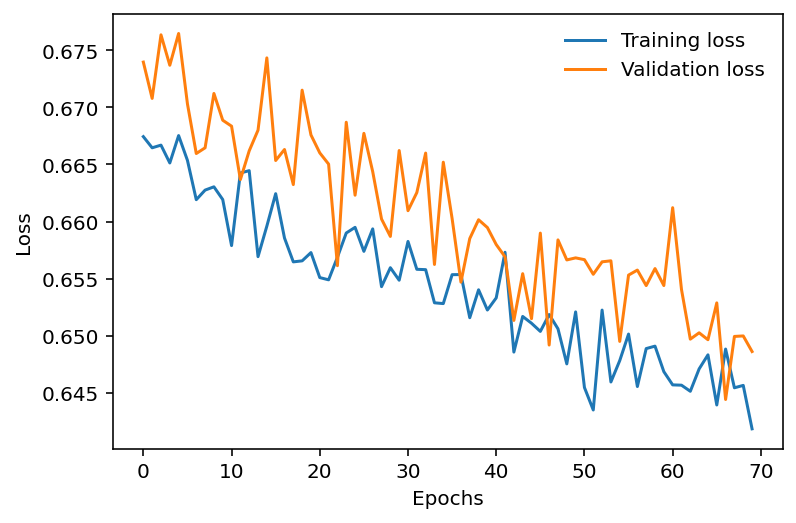

In [208]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)


### Gráfico de tasa de acierto del conjunto de entrenamiento y validación

In [210]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))




Test Accuracy of the model: 62.85 %


In [212]:
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 60.25 %


### Visualizar los mapas de activación

Mostrar los mapas de activación para un ejemplo de perro y otro para el ejemplo de gato.

## 3.4 Pruebas

Explicar como se realizarán los experimentos y su pruebas. 

Los experimentos del conjunto de pruebas dependen de los hiperparámetros obtenidos en el entrenamiento. Explicar como son fijados esos hiperparámetros para el conjunto de prueba.

In [209]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 61.9 %


In [ ]:
def custom_viz(kernels, path=None, cols=None, size=None, verbose=False, axis=False):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: Number of columns (doesn't work completely yet.)
    size: Tuple input for size. For example: size=(5,5)
    verbose: Print information about the input.
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
    C = kernels.shape[1]
    total_cols = N*C
    pos = range(1,total_cols + 1)
    
    if verbose:
        print("Shape of input: ", kernels.shape)
        
    if cols==None:
        req_cols = C
        num_rows = N
    elif cols:
        req_cols = cols
        # Account for more rows while diving total cols
        # with requested number of cols in the figure
        # Hence, using np.ceil to get the largest int
        # from the quotient of division.
        num_rows = int(np.ceil(total_cols/req_cols))
    elif C>1:
        # Check for 1D arrays and such. Mostly not needed.
        req_cols = C

    fig = plt.figure(1)
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(num_rows,req_cols,pos[k])
            ax.imshow(img, cmap='gray')
            if axis:
                plt.axis('on')
            elif axis==False:
                plt.axis('off')
            k = k+1
    if size:
        size_h,size_w = size
        set_size(size_h,size_w,ax)
    if path:
        plt.savefig(path, dpi=100)
    plt.show()

    

In [ ]:
kernels = model.conv1.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
custom_viz(kernels, '/content/conv1_weights.png', 4)

In [ ]:
# Dibujar el primer kernel
kernels = model.conv1.weight.cpu().detach().clone()
print(kernels.shape)

# Imprimir primer kernel
plt.imshow(kernels[0][0], cmap='gray')
plt.colorbar()


In [ ]:
from torch.autograd import Variable

# Ver imágenes filtradas en la primera capa convulocional
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(batch_idx, example_data.shape, example_targets)

# Obtenemos la primera imagen del conjunto de entrenamiento
# Un gato
cat = example_data[0]
print(number.shape)

# Mostramos la imagen del gato
plt.imshow(cat[0], cmap='gray')
plt.colorbar()

# Congelamos los datos de la imagen
cat.unsqueeze_(0)
cat = Variable(number, requires_grad=False)

# Aplicamos todos los filtros de la primera capa convulocional a la imagen
conv1_out = model.conv1.forward(cat.cuda())
print(conv1_out.shape)

# Creo una copia de todas las imágenes filtradas fuera de la GPU
conv1_out_cpu = conv1_out.cpu().detach().clone()

# Mostramos las primeras 60 imágenes filtradas
fig, axs = plt.subplots(nrows=5, ncols=12, figsize=(24, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for index, ax in enumerate(axs.flat):  
   ax.imshow(conv1_out_cpu[0][index], cmap='gray')


## 3.5 Resultados

Mostrar los resultados del entrenamiento y pruebas. 
Utilizar métricas para mostrar bondad del modelo.(Matríz de confusión)
Utilizar gráficos. Explicar los resultados obtenidos.

Debe construir una para entrenamiento y otra para pruebas

|            	| Perro Pred. 	| Gato Pred. 	 |
|------------	|:-------------:|:------------:|
| Perro Real 	|      00     	|     00     	 |
| Gato Real  	|      00     	|     00     	 |

### Métricas

Debe construir una para entrenamiento y otra para pruebas

|           	| Clase Perro 	| Clase Gato 	 |
|-----------	|:-------------:|:------------:|
| Precisión 	|    00.00%  	  |    00.00%  	 |
| Recall    	|    00.00%    	|    00.00%  	 |

| Tasa de Acierto Global 	| 00.00% 	|
|------------------------	|:------:	|




#4. Conclusiones

Conclusiones sobre el uso de la técnica. Ventajas y desventajas. ¿Se cumplen los objetivos del laboratorio?. ¿Como se comparan los resultados con los experimientos hechos en clases para el mismo problema?

